In [1]:
import nilearn
from nilearn import plotting
from nilearn import datasets
from nilearn import image
from nilearn.image import mean_img
from nilearn.image import index_img

import numpy as np
import pandas as pd

/Users/home/.local/lib/python3.8/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


## Averiguação da shape do dataset e importação do mesmo

In [2]:
import os

# Set variables
ROOT_DATA='/Users/home/Documents/BIDS/'
#ROOT_DATA='/home/brunomiguel/Documents/data/BIDS/'
SUB='sub-0001'
SES='ses-001'
TASK='innerspeech'
RUN='run-02'


# data folder
data_path=os.path.join(ROOT_DATA, SUB, SES)
print('The data is in this folder - ' + data_path)

# project folder
ROOT_PROJECT="/Users/home/Documents/GitHub/MVPA-speech_project"




fmri_img=os.path.join(data_path, 'func', 
                          SUB + '_' + SES + '_task-' + TASK + '_'+ RUN +'_bold_pp_standard.nii.gz')
dataset_shape=(image.load_img(fmri_img).shape)

print(dataset_shape)
dataset_shape[3]

The data is in this folder - /Users/home/Documents/BIDS/sub-0001/ses-001
(91, 109, 91, 258)


258

## Eventos

In [3]:
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix

tr = 2  # repetition time is ? second
n_scans = dataset_shape[3]  # the acquisition comprises ?? scans
frame_times = np.arange(n_scans) * tr  # here are the correspoding frame times

# load events.tsv
events_PATH=os.path.join(data_path, 'func', 
                          SUB + '_' + SES + 
                          '_task-' + TASK + '_'+ RUN + '_events.tsv')

events_df = pd.read_csv(events_PATH, sep='\t', na_values="n/a")


## Criação da tabela design_matrix (por fases e não betas)

In [4]:
hrf_model='spm'
design_matrix = make_first_level_design_matrix(frame_times, events_df,
                                    drift_model='polynomial', drift_order=3,
                                    hrf_model=hrf_model)

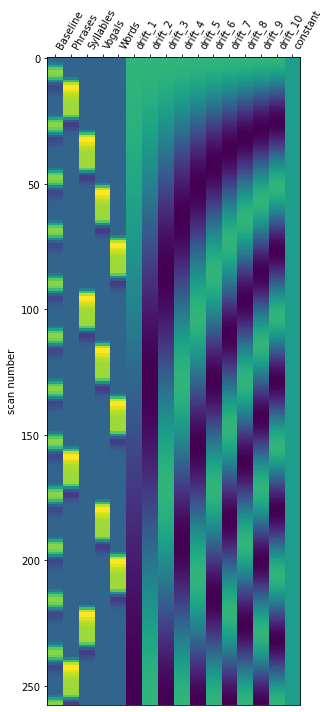

In [5]:
from nilearn.glm.first_level import FirstLevelModel

first_level_model = FirstLevelModel(tr)
first_level_model = first_level_model.fit(fmri_img, events=events_df)
design_matrix = first_level_model.design_matrices_[0]
plot_design_matrix(design_matrix)

In [6]:
contrast_matrix = np.eye(design_matrix.shape[1])
basic_contrasts = dict([(column, contrast_matrix[i])
                        for i, column in enumerate(design_matrix.columns)])
basic_contrasts

{'Baseline': array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'Phrases': array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'Syllables': array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'Vogals': array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'Words': array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'drift_1': array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'drift_2': array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'drift_3': array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'drift_4': array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
 'drift_5': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]),
 'drift_6': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]),
 'drift_7': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.

In [7]:
fmri_glm4mask = FirstLevelModel()
fmri_glm4mask = fmri_glm4mask.fit(fmri_img, design_matrices=design_matrix)

## Beta-series

In [8]:
onset=[]
duration=[]
trialtype=[]

labels=[]

onsett=0
evtt=0

for idx in range(len(events_df)-1):
    block_event=events_df.loc[idx]

    num_evts=block_event['duration']/tr

    for evt in range(int(num_evts)):

        onset.append(onsett)
        onsett+=tr

        duration.append(tr)

        trialtype.append(evtt)
        evtt+=1

        labels.append(block_event['trial_type'])


events_bs = pd.DataFrame({'trial_type': trialtype,
                       'onset': onset,
                       'duration': duration})
events_bs

,trial_type,onset,duration
0,0,0,2
1,1,2,2
2,2,4,2
3,3,6,2
4,4,8,2
...,...,...,...
247,247,494,2
248,248,496,2
249,249,498,2
250,250,500,2


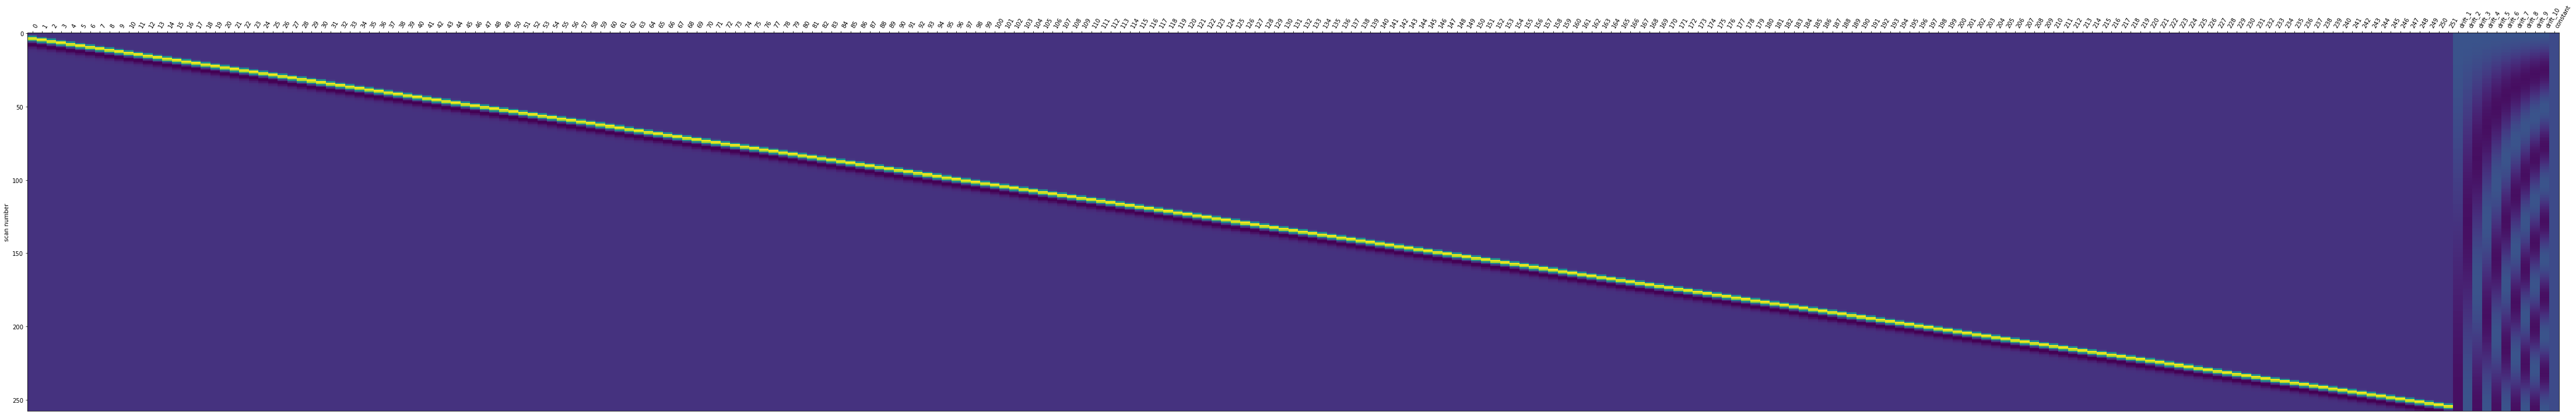

In [9]:
first_level_model = FirstLevelModel(tr)
first_level_model = first_level_model.fit(fmri_img, events=events_bs)
design_matrix_b_series = first_level_model.design_matrices_[0]
plot_design_matrix(design_matrix_b_series)
design_matrix_b_series.drop({'drift_1', 'drift_2', 'drift_3', 'drift_4', 'drift_5', 'drift_6', 'drift_7', 'drift_8', 'drift_9', 'drift_10', 'constant'}, axis='columns', inplace=True)

## Contrastes

In [10]:
contrast_matrix_b_series = np.eye(design_matrix_b_series.shape[1])
basic_contrasts_b_series = dict([(column, contrast_matrix_b_series[i]) for i, column in enumerate(design_matrix_b_series.columns)])
    

fmri_glm = FirstLevelModel()
fmri_glm = fmri_glm.fit(fmri_img, design_matrices=design_matrix_b_series)

mean_image = mean_img(fmri_img)
z_map=[]

for idx in range(len(basic_contrasts_b_series)):
    z_map.append(fmri_glm.compute_contrast(basic_contrasts_b_series[idx], output_type='z_score'))
    

In [11]:
contrast_matrix_b_series.shape

(252, 252)

In [12]:
len(basic_contrasts_b_series)

252

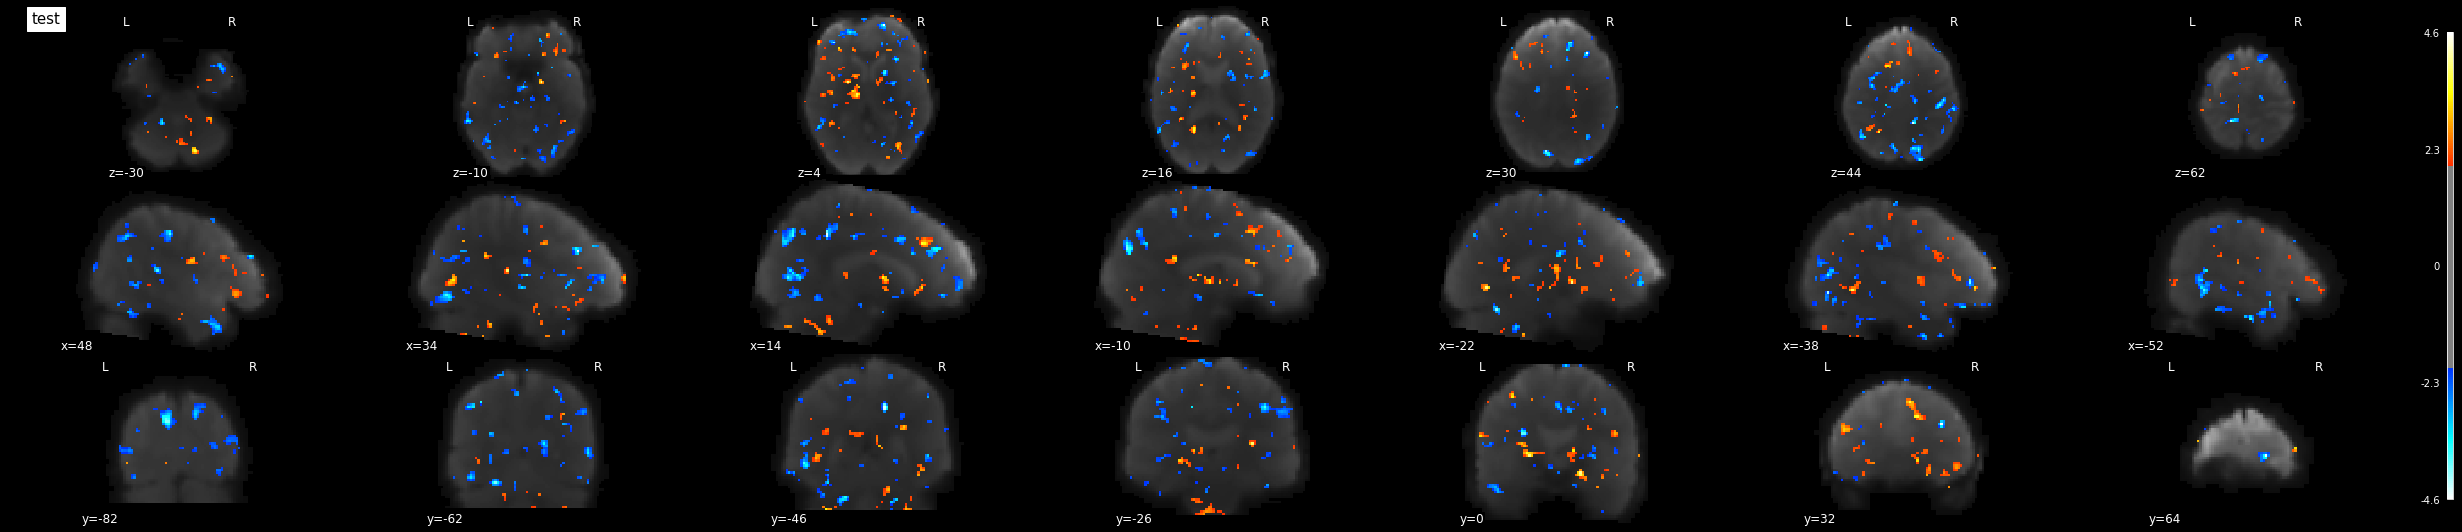

In [13]:
#Teste de imagem
plotting.plot_stat_map(
    z_map[1], bg_img=mean_image, threshold=2, display_mode='mosaic', black_bg=True, title='test')
plotting.show()

In [28]:

#bs_fn=os.path.join(data_path, 'func', SUB + '_' + SES + '_task-' + TASK + '_'+ RUN +'_bold_bs.nii.gz')
import nibabel as nib

bs_fn=os.path.join( SUB + '_' + SES + '_task-' + TASK + '_'+ RUN +'_bold_bs.nii.gz')

img4D=nilearn.image.concat_imgs(z_map)
img4D.to_filename(bs_fn)

## As linhas abaixo será para criação de máscaras

In [14]:
#contraste entre frases e baseline
basic_contrasts['+Phrases-Baseline'] = (
    basic_contrasts['Phrases']
    - basic_contrasts['Baseline'])

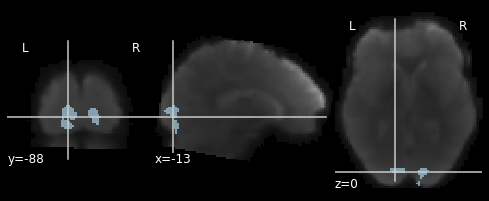

In [33]:
from nilearn.input_data import NiftiMasker

masker = NiftiMasker()

brain_mask_map = fmri_glm4mask.compute_contrast(basic_contrasts['+Phrases-Baseline'], output_type='z_score')

brain_mask= nilearn.image.threshold_img(brain_mask_map, threshold=8, copy=False)
masker.fit(brain_mask)
brain_mask=masker.mask_img_
plotting.plot_roi(brain_mask, bg_img=mean_image,
                  cmap='Paired')

mask_fn=os.path.join( SUB + '_' + SES + '_task-' + TASK + '_'+ RUN +'_mask.nii.gz')
brain_mask.to_filename(mask_fn)

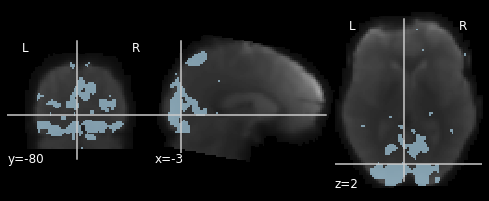

In [32]:
# debug
brain_mask_map= nilearn.image.load_img(mask_fn)

plotting.plot_roi(brain_mask, bg_img=mean_image,
                  cmap='Paired')

## Importação da brain_mask (caso se queira usar gm)

In [ ]:
brain_mask = datasets.load_mni152_brain_mask()

from nilearn.datasets import fetch_icbm152_brain_gm_mask
brain_mask = fetch_icbm152_brain_gm_mask()

## Cross-validation

In [22]:
len(labels)

252

In [24]:
from sklearn.model_selection import KFold
from nilearn.decoding import Decoder 

cv = KFold(n_splits=3)

fold = 0
for train, test in cv.split(labels):
    fold += 1
    decoder = Decoder(estimator='svc', mask=brain_mask, standardize=True)
    decoder.fit(index_img(z_map, train), [labels[i] for i in train])
    prediction = decoder.predict(index_img(z_map, test))
    print(
        "CV Fold {:01d} | Prediction Accuracy: {:.3f}".format(
            fold,
            (prediction == [labels[i] for i in test]).sum() / float(len(
                test))))

/Users/home/.local/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is smaller than .5% of the volume human brain. This object is probably not tuned tobe used on such data.
  screening_percentile_ = _adjust_screening_percentile(
/Users/home/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/home/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/home/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/home/opt/anaconda3/lib/python3.8/site-packages/sklea

CV Fold 1 | Prediction Accuracy: 0.155


/Users/home/.local/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is smaller than .5% of the volume human brain. This object is probably not tuned tobe used on such data.
  screening_percentile_ = _adjust_screening_percentile(
/Users/home/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/home/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/home/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/home/opt/anaconda3/lib/python3.8/site-packages/sklea

CV Fold 2 | Prediction Accuracy: 0.250


/Users/home/.local/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is smaller than .5% of the volume human brain. This object is probably not tuned tobe used on such data.
  screening_percentile_ = _adjust_screening_percentile(
/Users/home/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/home/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/home/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/home/opt/anaconda3/lib/python3.8/site-packages/sklea

CV Fold 3 | Prediction Accuracy: 0.202


In [25]:
np.unique(labels)

array(['Baseline', 'Phrases', 'Syllables', 'Vogals', 'Words'], dtype='<U9')

In [35]:

decoder = Decoder(estimator='svc',cv=3, mask=brain_mask, standardize=True)
decoder.fit(z_map, labels)


/Users/home/.local/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is smaller than .5% of the volume human brain. This object is probably not tuned tobe used on such data.
  screening_percentile_ = _adjust_screening_percentile(
/Users/home/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/home/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/home/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/home/opt/anaconda3/lib/python3.8/site-packages/sklea

TypeError: must be real number, not numpy.str_

In [52]:
cv_scores=[]
for i, (param, cv_score) in enumerate(zip(decoder.cv_params_,
                                          decoder.cv_scores_)):

    print(i)
    print(decoder.cv_scores_)
    cv_scores=np.mean(decoder.cv_scores_['Phrases'])
    
    with open('results.txt', 'a+') as f:
        print("Fold %d | score: %.3f" % (i + 1, cv_scores),file=f)
        

0
{'Baseline': [0.5458333333333334, 0.5243055555555556, 0.5020833333333334], 'Phrases': [0.5468599033816426, 0.5903381642512077, 0.4753623188405797], 'Syllables': [0.5062801932367149, 0.5304347826086956, 0.5285024154589373], 'Vogals': [0.4975845410628019, 0.5352657004830919, 0.5033816425120774], 'Words': [0.4975845410628019, 0.5565217391304348, 0.5246376811594202]}
1
{'Baseline': [0.5458333333333334, 0.5243055555555556, 0.5020833333333334], 'Phrases': [0.5468599033816426, 0.5903381642512077, 0.4753623188405797], 'Syllables': [0.5062801932367149, 0.5304347826086956, 0.5285024154589373], 'Vogals': [0.4975845410628019, 0.5352657004830919, 0.5033816425120774], 'Words': [0.4975845410628019, 0.5565217391304348, 0.5246376811594202]}
2
{'Baseline': [0.5458333333333334, 0.5243055555555556, 0.5020833333333334], 'Phrases': [0.5468599033816426, 0.5903381642512077, 0.4753623188405797], 'Syllables': [0.5062801932367149, 0.5304347826086956, 0.5285024154589373], 'Vogals': [0.4975845410628019, 0.535265

In [55]:
decoder.cv_scores_


{'Baseline': [0.5458333333333334, 0.5243055555555556, 0.5020833333333334],
 'Phrases': [0.5468599033816426, 0.5903381642512077, 0.4753623188405797],
 'Syllables': [0.5062801932367149, 0.5304347826086956, 0.5285024154589373],
 'Vogals': [0.4975845410628019, 0.5352657004830919, 0.5033816425120774],
 'Words': [0.4975845410628019, 0.5565217391304348, 0.5246376811594202]}